# 02 - Portfolios

In this notebook you can find simple examples that showcase how to programatically create portfolios.

In [1]:
import sys
sys.path.insert(0, '../')
%reload_ext autoreload
%autoreload 2
%pip install seaborn

You should consider upgrading via the '/home/saheru/Documents/Programming/Finance/IBKR/ibeam/env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Start server

The `Server` class is the interface to perform HTTPS requests to acquire data regarding instruments, like stocks.

In [2]:
import time
import logging

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from modules.server import Server
from modules.instruments import Portfolio

In [3]:
srv = Server()
srv.start()

# the following silences the logging output
logging.getLogger('ibkr-algotrading').setLevel(logging.ERROR)

Once started, we can request information on any stock we want simply by accesing items in `srv`. These will be cached, so only the first access will have significant delay.

First, it is a good idea to know which is our balance,

In [4]:
srv.balance

(1000000.0, 'USD')

> NOTE: with a simulated IBKR Paper Account you start with 1'000'000 USD, which you can use to test out trading.

## Create Portfolio

we can now request some stocks and create a portfolio with them,

In [5]:
stocks = srv[['SPY', 'XOM', 'MSFT', 'AAPL', 'TSLA'], '1y', '1d']

portfolio = Portfolio(wealth=100, stocks=stocks)

The `wealth` argument is in the same currency as our account's balance.

We can now check how much fraction of stock is allocated for each of the stocks.

Of course, right now we haven't bought any stock so it's all zero,

In [6]:
portfolio.alloc

array([0., 0., 0., 0., 0.])

Similarly, our distribution of wealth accross the stocks looks like an all-zero array, and
this is the only time it will be like so before we perform our first order.

In any other case the "weights" will sum up to 1.

In [7]:
portfolio.weights

array([0., 0., 0., 0., 0.])

we finally add the portfolio to the server so it knows about its existance,

In [8]:
srv.add_portfolio(portfolio)

## Place an order on our portfolio

To prevent accidentally losing all of our money, we will trade under a simulated context in which orders are only previewed but we still get whole information on what would happen,

In [9]:
with srv.simulated():
    # 1st order
    # distribute the portfolio equally accross stocks
    weights = np.ones(5) / 5.0
    print('1st order')
    portfolio.order(weights)

    # the wealth of the portfolio decreases since the
    # transactions take a commission
    W = portfolio.wealth()
    print('Portfolio wealth: ', W)
    print('Total commissions:', portfolio.commission, 'Wealth + commission: ', W + portfolio.commission)

    # 2nd order
    # we will put all our money on SPY
    weights[0] = 1.0
    weights[1:] = 0.0
    print('2nd order')
    portfolio.order(weights)

    W = portfolio.wealth()
    print('Portfolio wealth: ', W)
    print('Total commissions:', portfolio.commission, 'Wealth + commission: ', W + portfolio.commission)

    # 3rd order
    # now we will give a litle to XOM
    weights[0] = 0.9
    weights[1] = 0.1
    print('3rd order')
    portfolio.order(weights)

    W = portfolio.wealth()
    print('Portfolio wealth: ', W)
    print('Total commissions:', portfolio.commission, 'Wealth + commission: ', W + portfolio.commission)

    # we can also list all orders that have happened on this portfolio.
    # the stored values are the stock shares
    print('Portfolio orders:')
    print(portfolio.orders)

1st order
Portfolio wealth:  99.02361400000001
Total commissions: 0.9900990000000001 Wealth + commission:  100.01371300000001
2nd order
Portfolio wealth:  98.02612
Total commissions: 1.9705308119778602 Wealth + commission:  100.00098681197788
3rd order
Portfolio wealth:  97.063008
Total commissions: 2.9411293765293003 Wealth + commission:  100.0041373765293
Portfolio orders:
                               SPY     XOM    MSFT    AAPL    TSLA
2021-08-31 17:44:55.406606  0.0438  0.3600  0.0652  0.1304  0.0269
2021-08-31 17:44:58.684041  0.2168  0.0000  0.0000  0.0000  0.0000
2021-08-31 17:45:03.134897  0.1932  0.1764  0.0000  0.0000  0.0000


Notice how the portfolio's overall wealth decreases after each order since there are commissions.

Also note that after we exit the simulated context, the whole state of the server will be restored, meaning all orders in the
portfolio will disappear and it will return to its previous state.

In [10]:
# after exiting the simulation, the portfolio does not have any orders
print('Portfolio orders:')
print(portfolio.orders)

Portfolio orders:
Empty DataFrame
Columns: []
Index: []


## Place an order back-in-time and check statistics

In a simulated context we can also "place orders" in the past by using historical data. This allows us to easily study the performance of the portfolio. 

> NOTE: back-in-time orders only work in a simulated context.

1st date of order: 2020-09-01 12:21:18.093784
1st order
Today's portfolio wealth:  128.48735000000002
commission: 0.9900990000000001 Today's wealth + commission:  129.477449
2nd order
Today's portfolio wealth:  126.989915
commission: 1.92892590150282 Today's wealth + commission:  128.91884090150282
Portfolio orders:
                               SPY     XOM  MSFT  AAPL  TSLA
2020-09-01 12:21:18.093784  0.2806  0.0248   0.0   0.0   0.0
2020-10-01 12:21:18.093784  0.2803  0.0000   0.0   0.0   0.0
60 day Sharpe ratio:    -1.9954453806375703
Half year Sharpe ratio: 1.1100873707266348
60 day average returns: -0.001729148111057931
60 day std of returns:  0.013939043177760027


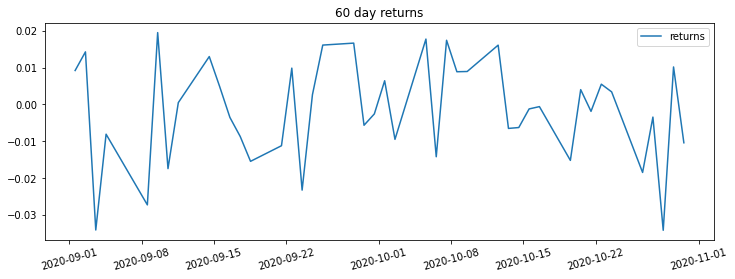

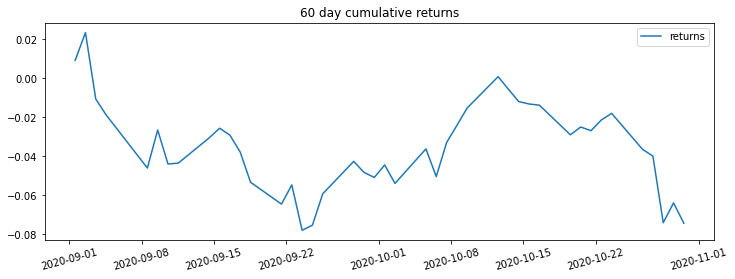

Exception in thread Thread-26:
Traceback (most recent call last):
  File "/usr/lib/python3.9/threading.py", line 954, in _bootstrap_inner
    self.run()
  File "../modules/utils.py", line 43, in __run
    self.__run_backup()
  File "/usr/lib/python3.9/threading.py", line 892, in run
    self._target(*self._args, **self._kwargs)
  File "../modules/server.py", line 419, in _hist_update
    for f in futures:
  File "/usr/lib/python3.9/concurrent/futures/_base.py", line 445, in result
    return self.__get_result()
  File "/usr/lib/python3.9/concurrent/futures/_base.py", line 390, in __get_result
    raise self._exception
  File "/usr/lib/python3.9/concurrent/futures/thread.py", line 52, in run
    result = self.fn(*self.args, **self.kwargs)
  File "../modules/server.py", line 384, in _stk_thread
    today = datetime.today().timestamp()
  File "/home/saheru/Documents/Programming/Finance/IBKR/ibeam/env/lib/python3.9/site-packages/pandas/core/indexes/extension.py", line 279, in __getitem__
 

In [42]:
# we will use as order date one year before today
first_date = pd.Timestamp.today() - pd.Timedelta(days=365)
print('1st date of order:', first_date)

with srv.simulated():
    # 1st order
    # distribute the portfolio equally accross stocks
    date = first_date
    weights = np.ones(5) / 5.0
    weights[0] = 0.99
    weights[1] = 0.01
    weights[2:] = 0.0
    print('1st order')
    portfolio.order(weights, date=date)

    W = portfolio.wealth()
    print('Today\'s portfolio wealth: ', W)
    print('commission:', portfolio.commission, 'Today\'s wealth + commission: ', W + portfolio.commission)

    # 2nd order
    # we will put all our money on SPY one month **after** the previous order
    date = date + pd.Timedelta(days=30)
    weights[0] = 1.0
    weights[1:] = 0.0
    print('2nd order')
    portfolio.order(weights, date=date)

    W = portfolio.wealth()
    print('Today\'s portfolio wealth: ', W)
    print('commission:', portfolio.commission, 'Today\'s wealth + commission: ', W + portfolio.commission)

    # all orders that have happened on this portfolio.
    # the stored values are the stock shares
    print('Portfolio orders:')
    print(portfolio.orders)

    # we can also access the portfolio's statistics
    print('60 day Sharpe ratio:   ', portfolio.sharpe(end_date=first_date + pd.Timedelta(days=60)))
    print('Half year Sharpe ratio:', portfolio.sharpe(end_date=first_date + pd.Timedelta(days=365/2)))
    returns = portfolio.get_returns(end_date=first_date + pd.Timedelta(days=60))
    print('60 day average returns:', returns.mean().values[0])
    print('60 day std of returns: ', returns.std().values[0])
    # plot cumulative returns
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=returns)
    plt.title('60 day returns')
    plt.xticks(rotation=15)
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=returns.cumsum())
    plt.title('60 day cumulative returns')
    plt.xticks(rotation=15)